# Help Mates ! Is flocking a surviving behavior ?

In this notebook, we plot the evolution of some genes of the preys to analyze how they react to the presence of predators in their environments

### 1 - Helper functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
def unpackData(txtFilePath):
    '''Takes as input the text file that was created by Unity and changes it to a pd.DataFrame'''
    if(txtFilePath[-10:] == "latest.txt"):
        print("WARNING: rename file before it is overwritten by next simulation")
    df = pd.read_csv(txtFilePath, sep=";")
    
    print(f'Successfully unpacked the text file: dataframe of size {df.shape}')
    print(df.head())

    return df

In [5]:
colors = {
    'resultsTargetWeights': (1, 0.549, 0),
    'resultsAlignWeights':  (0.5, 0, 0.5),
    'resultsCohesionWeights':  (0, 0.5, 0),
    'resultsSeparateWeights': (0, 0.5, 0.5),
    'resultsNumPreys': (0.227, 0.458, 0.702),
    'resultsNumPredators': (0.827, 0.192, 0.220)
}

sns.set_theme()
def plotSimulationResults(df):
    xAxis = [i for i in range(df.shape[0])]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,10), sharex=True)

    for colTitle in df.columns:
        if('Weights' in colTitle):
            ax2.plot(xAxis, df[colTitle].values, color = colors[colTitle], label = colTitle)
        
        elif('Num' in colTitle):
            ax1.plot(xAxis, df[colTitle].values, color = colors[colTitle], label = colTitle)

    ax1.set_title("Evolution of the number of animals")
    ax1.legend()

    ax2.set_title("Evolution of the behaviour of the BOIDS preys")
    ax2.legend()

    fig.suptitle("Simulation Results")
    # Adjust spacing between subplots to avoid overlapping labels
    plt.tight_layout()

    # Display the plots
    plt.show()

## Simulation Results with no predators

Add simulation results when there is no group behaviour

- Number of preys: 100
- Number of predators: 0

The preys can only focus on finding (and learning how to find) their food on the terrain

Successfully unpacked the text file: dataframe of size (5420, 6)
   resultsTargetWeights  resultsAlignWeights  resultsCohesionWeights  \
0              0.466023             0.536482                0.455836   
1              0.466093             0.536399                0.455394   
2              0.466170             0.536316                0.454931   
3              0.466255             0.536232                0.454449   
4              0.466347             0.536146                0.453949   

   resultsSeparateWeights  resultsNumPreys  resultsNumPredators  
0                0.526391               50                    0  
1                0.526271               50                    0  
2                0.526153               50                    0  
3                0.526035               50                    0  
4                0.525914               50                    0  


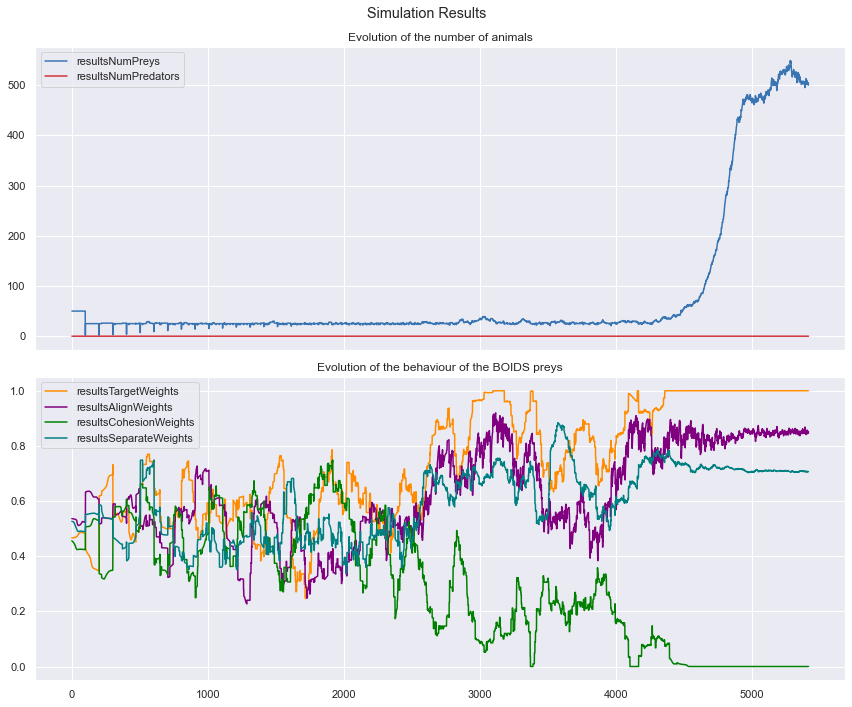

In [7]:
noPredatorDf = unpackData('results/resultsNoPredators.txt')

plotSimulationResults(noPredatorDf)

After a few thousands of iterations, we see that the prey focus more on the direction of the food they detect.
It may have took a while for them to learn how to eat, but once they learned that, they ignore the rest of the group: the cohesion weight dratically decreases to almost 0. The separation weight fluctuates a little bit between $[0.4;0.6]$. Even geared towards food, the preys still need their vital space and don't want to collide.
The weights for alignment with the rest of the group also increases. It is a bit surprising to see that preys tend to go towards the same direction as their peers. Maybe they can think that their fellows might have spotted food, so it is possible that there is more food in the direction of the group.

After 5000 iterations, the number of preys stabilizes, as there is not enough food for them to proliferate. Had we increased the *Vegetation Growth Rate* or the *energy* of the preys, this number would have kept increasing.

For now, it was a very quiet, safe place for our preys...  but it won't last for long!

## Adding predators to the scene

The preys can spot predators but don't know how to behave in their presence. This is the goal of this study to observe if the **herd or flock** behavior is a meachnism trigger to increase their survival.

The predators have no brain, and their behavior is like a *Finite State Machine*, and chooses its action based on its **hunger** (*energy*) and it **urge to reproduce** (*urgeToReproduce*):
- if a predator is more hungry, it will only try to detect preys
- if it wants to reproduce, it will only try to detect mates (without gender difference for the moment)
- Once it has detected its **target**, he tracks it relentlessly and does not use its vision (except for collision avoidance with obstacles such as trees). He starts searching again if he has reached its target, or if it's target is dead or has escaped (*distance > maxTrackingDistance*)

### 1 - Fine tuning of the parameters to reach an equilibrium within the ecosystem

Reaching an equilibrium requires precise fine-tuning of the parameters through a lot of trial and errors, as a lot of parameters can influence the ecosystem:
- **Perks of the preys** (initial number, speed range, vision reach of food/predators/peers, initial weights given to possible behaviours, maximal level of energy, loss of energy at each frame)
- **Perks of the predators** (initial number, speed range, vision reach of preys/peers, maximal level of energy/urge to reoproduce, loss at every frame, maximal tracking distance)
- **External environment**: number/density of obstacles (maybe harder for predators to track preys), terrain topography (mountains, water, zones where certain animals can't go), spawn zones (grass spawn tweaked by height, steepness)

We thus made some **strong hypothesis** for this simulation, whether based on natural observations/intuitions or needed to simplify our method
- Natural observations:
    1. There are more preys than predators
    2. Mean predators' speed is higher than that of preys, and predators go faster when they are in danger of starvation/ high urge to reproduce.
    3. Predators have a more accurate vision than preys to compensate for their lower number.


- Simplifying hypothesis:
    1. No obstacles or few obstacles
    2. No inaccessible zones on the terrain: preys and predators can go where they want
    3. Grass spawn is random on all the terrain
    4. The speed of our agents will be far higher than that we could see in reality so we can observe behaviours faster than with a more close-to-real simulation
    5. We keep the populations to a minimum (half the initial poopulation size) to give the time and opportunity to learn behaviours to the preys.

Here are the default values that can be used to reach an equilibrium on a neutral terrain:

| Variable Name         | Default Prey Params  | Default Predator Params |
| ---------------------- | ----------------------- | ----------------------- |
| maxAngle              | 10.0f                  | 1f                  |
| minSpeed              | 3f                     | 0.3f                     |
| maxSpeed              | 7f                    | 0.7f                    |
| perceptionRadius      | 20f                   | X                        |
| avoidanceRadius       | 5f                      | X                        |
| maxSteerForce         | 3                      | X                        |
| swapRate              | 0.01f                  | 0.01f                  |
| mutateRate            | 0.01f                  | 0.01f                  |
| swapStrength          | 10.0f                  | X                        |
| mutateStrength        | 0.5f                   | X                        |
| maxEnergy             | 10.0f                  | 20.0f                  |
| lossEnergy            | 0.1f                   | 0.1f                   |
| gainEnergy            | 10.0f                  | 5.0f                  |
| maxReproduce            | X                  | 40f                  |
| urgeReproduceRate            | X                   | 0.1f                   |
| gainReproduceRate            | X                  | 20.0f                  |
| maxVision             | 20.0f                  | 30f                         |
| stepAngle             | 10.0f                  | 5f                        |
| nEyes                 | 5                      | X                        |
| preyMask          | X          | [LayerMask]            |
| predatorMask          | [LayerMask]            | [LayerMask]            |
| PredStepAngle         | 5.0f                   | X                        |
| nPredEyes             | 10                     | 20                        |
| obstacleMask          | [LayerMask]            | [LayerMask]            |
| boundsRadius          | .5f                   | 1.5                        |
| avoidCollisionWeight  | 10                     | 10                        |
| collisionAvoidDst     | 7                      | 7                        |

Successfully unpacked the text file: dataframe of size (4455, 6)
   resultsTargetWeights  resultsAlignWeights  resultsCohesionWeights  \
0              0.425834             0.520160                0.577452   
1              0.425696             0.520106                0.577341   
2              0.425567             0.520041                0.577251   
3              0.425446             0.519960                0.577179   
4              0.425345             0.519854                0.577125   

   resultsSeparateWeights  resultsNumPreys  resultsNumPredators  
0                0.574216              100                    5  
1                0.574332              100                    5  
2                0.574447              100                    5  
3                0.574560              100                    5  
4                0.574667              100                    5  


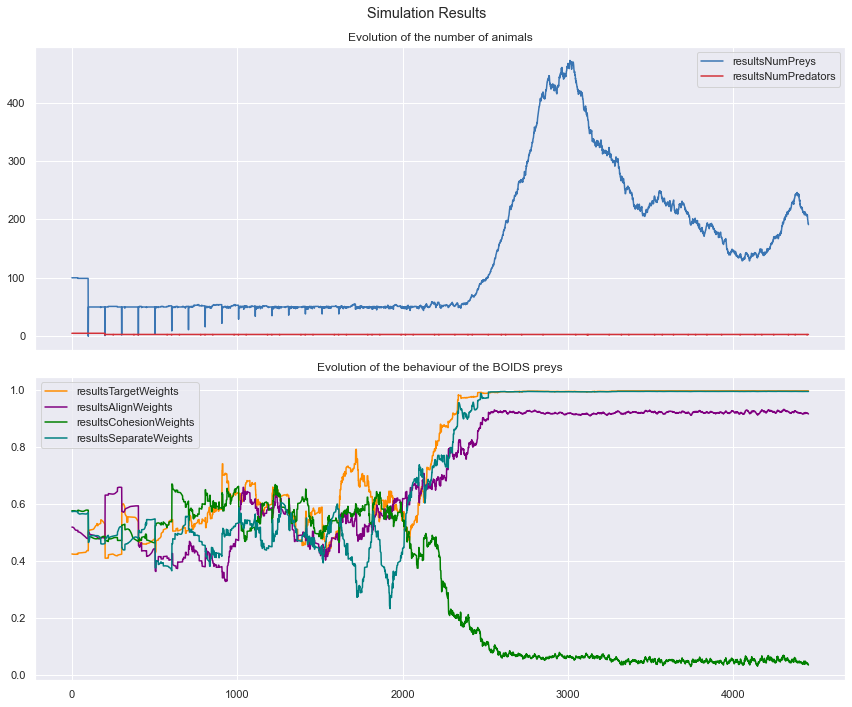

In [8]:
default100_5Df = unpackData('results/resultsDefault100-5.txt')

plotSimulationResults(default100_5Df)

At that point, the predators find to eat most of the time, bu don't find their peers to mate, so they eventually die. Let's increase the number of predators.

Successfully unpacked the text file: dataframe of size (5378, 6)
   resultsTargetWeights  resultsAlignWeights  resultsCohesionWeights  \
0              0.544387             0.575740                0.473507   
1              0.543766             0.575596                0.473718   
2              0.543153             0.575449                0.473926   
3              0.542556             0.575300                0.474131   
4              0.541982             0.575149                0.474333   

   resultsSeparateWeights  resultsNumPreys  resultsNumPredators  
0                0.632856               30                   20  
1                0.632760               30                   20  
2                0.632668               30                   20  
3                0.632582               30                   20  
4                0.632502               30                   20  


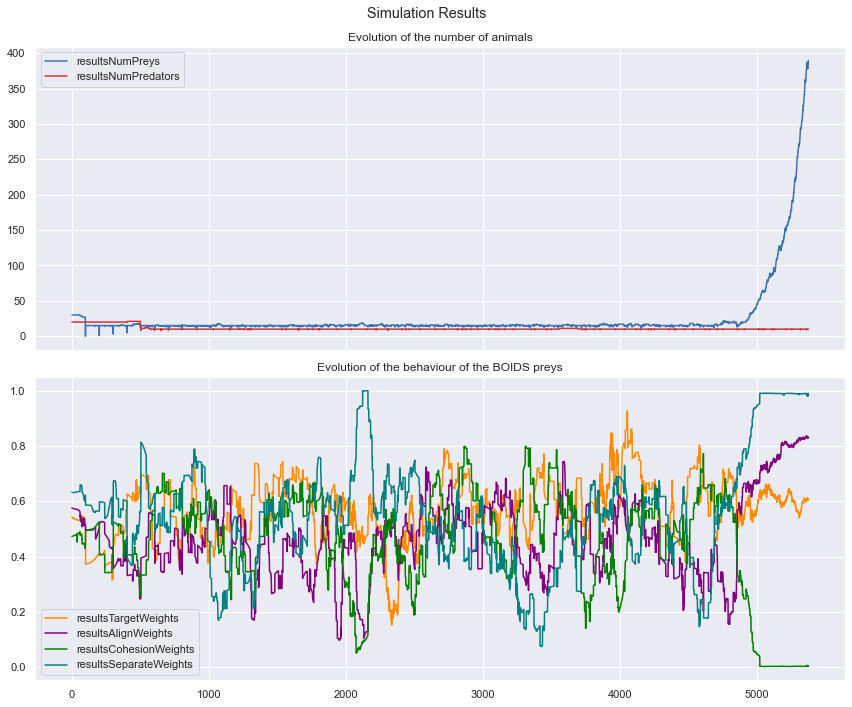

In [9]:
DF30_20A = unpackData('results/resultsDefault30-20.txt')

plotSimulationResults(DF30_20A)

Successfully unpacked the text file: dataframe of size (5541, 6)
   resultsTargetWeights  resultsAlignWeights  resultsCohesionWeights  \
0              0.534785             0.452070                0.514652   
1              0.534613             0.451989                0.514103   
2              0.534455             0.451837                0.510460   
3              0.534287             0.451764                0.510170   
4              0.534118             0.451815                0.510810   

   resultsSeparateWeights  resultsNumPreys  resultsNumPredators  
0                0.512373               50                   20  
1                0.511771               50                   20  
2                0.511206               50                   20  
3                0.510690               50                   20  
4                0.510228               50                   20  


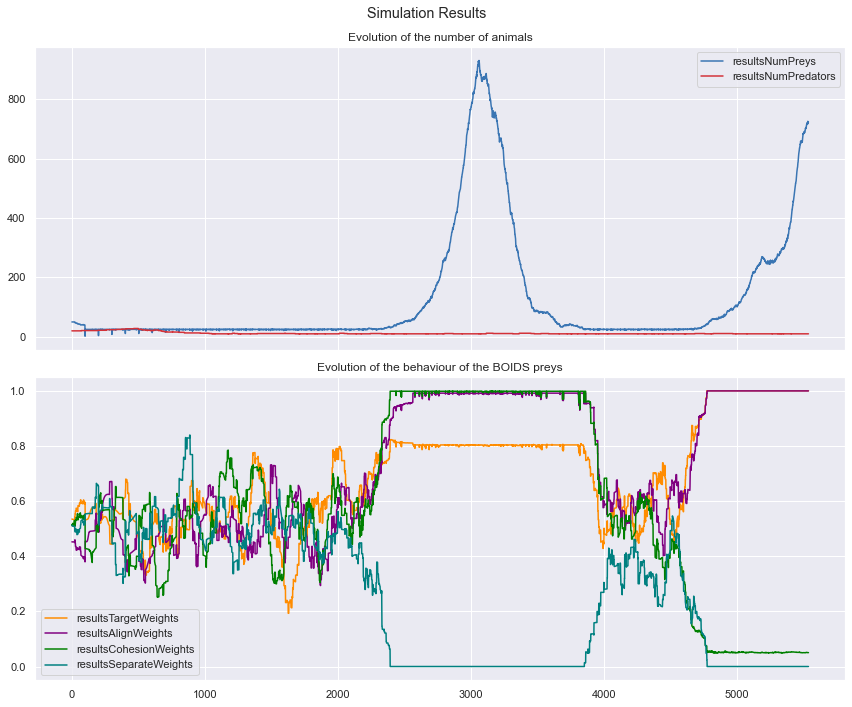

In [10]:
DF30_20B = unpackData('results/results30-20.2.txt')

plotSimulationResults(DF30_20B)

Successfully unpacked the text file: dataframe of size (5421, 6)
   resultsTargetWeights  resultsAlignWeights  resultsCohesionWeights  \
0              0.432695             0.557845                0.430015   
1              0.411460             0.541111                0.410444   
2              0.409798             0.541393                0.410517   
3              0.408168             0.541196                0.410584   
4              0.406590             0.541253                0.410680   

   resultsSeparateWeights  resultsNumPreys  resultsNumPredators  
0                0.519283               29                   20  
1                0.526151               29                   20  
2                0.526161               29                   20  
3                0.525930               29                   20  
4                0.526559               29                   20  


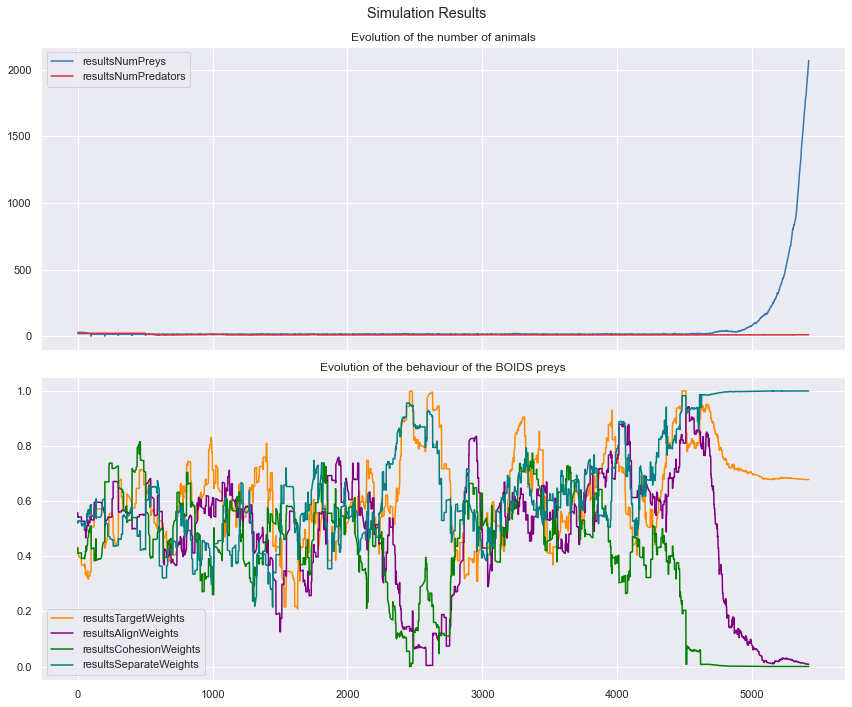

In [11]:
DF30_20C = unpackData('results/results30-20C.txt')

plotSimulationResults(DF30_20C)

Even while increasing the perks of the predators and their number, they eventually get outbrained by the preys, that learned to spot them. However, the preys try to go on their own rather than going together. Indeed, the weights for alignment and cohesion drastically decreases around 0. 

Let's try to let the prey eat and learn only to eat and then suddenly spawn predators to asses their adaptation.

Successfully unpacked the text file: dataframe of size (11594, 6)
   resultsTargetWeights  resultsAlignWeights  resultsCohesionWeights  \
0              0.452486             0.417316                0.515920   
1              0.452250             0.417363                0.515994   
2              0.452035             0.417416                0.516062   
3              0.451841             0.417473                0.516125   
4              0.451665             0.417534                0.516185   

   resultsSeparateWeights  resultsNumPreys  resultsNumPredators  
0                0.498547              100                    0  
1                0.498507              100                    0  
2                0.498481              100                    0  
3                0.498470              100                    0  
4                0.498476              100                    0  


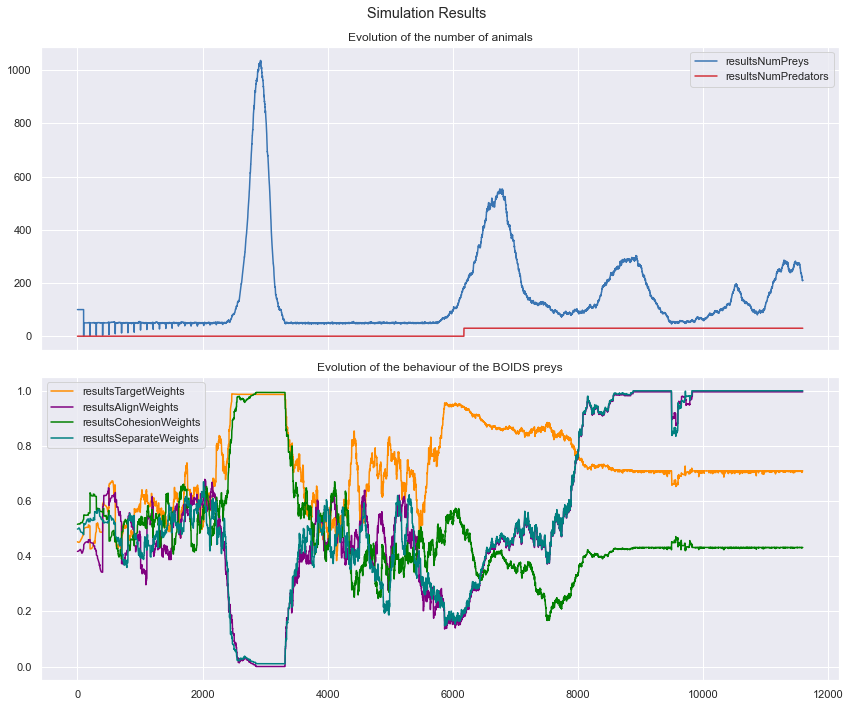

In [12]:
DFSudden = unpackData('results/suddenSpawn.txt')

plotSimulationResults(DFSudden)

The results we get here are interesting. First, as there are no predators,the preys first learn how to eat, thus the population increases drastically, until the grass reserves disappear. The population almost go to extinction, and then start to increase again. Thus the target weight increases again.

Then, we spawned 30 invincible predators on the terrain, that only want to devour preys. Preys, in response, start to adapt, and their align and separation weights start to increase. On the contrary, the target weight slowly decreases, but still has an important weight. The cohesion weight diminishes a lot.

**Interpretation:**
- Phase 1: The preys give more importance to finding their food and to cohesion. When there was not any predator in the precedent models, the align weight was high, and the cohesion weight was low. Maybe in this context of 0-predator, there are several optima for the brain.
- Phase 2: When adding the predators, the population decreases, and then starts to adapt, by being more geared towards the group behaviour

## Final word on our modelisation

This little simulation has shown that indeed, we can think that preys naturally flock or herd to avoid some predators. However, it does not explain why they do this, thee are several hypothesis in the literature:
- Maybe they align with others in case of of their fellows il fleeing from a predator
- It is a selfish beahviour: "I am less likely to be eaten among others"
- The number of eyes to detect potential predators is increased

We still have a good idea about adaptation in a natural environment, but let us remind that this is only under the strong hypothesis we made to simplify our study:
- The predators have no brain
- The preys do not have to meet another peer to reproduce (this could incerase the herd behaviour)
- There are no genders

And many, many others... If you want to know more about boids, flocks and whether it is a natural or not, I put some very interesting links in the README of this project.